# DNN for Oxford IIIT Pets Image Sets
### Created: Kriza Baby
#### 27 May 2022 - UTSA San Antonio, TX


In [134]:
# importing needed libs

import numpy as np
import pandas as pd
import os
from pathlib import Path, PosixPath
from os import listdir
from os.path import isfile, join
import cv2
import glob


import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , MaxPooling1D,Flatten , Dropout, AveragePooling2D, GlobalMaxPooling1D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam



# import tensorflow as tf
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()



from tensorflow.compat.v1.keras import backend as K


from tensorflow.compat.v1.keras.utils import to_categorical

from sklearn.metrics import classification_report,confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 999

In [ ]:
# access and download the data files to working folder
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
# untar the image files
!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz

In [ ]:
!ls images


In [135]:
cwd = os.getcwd()
# print(cwd)
path_img = Path(cwd +'/images')
annotation_img = Path(cwd + '/annotations')
# print(path_img, annotation_img)

In [ ]:
# # get all image names in the directory
# img_filenames = [f for f in listdir(path_img) if (isfile(join(path_img, f))) & (re.match(r'[0-9]+.*\.jpg', f))]
# print(len(img_filenames), img_filenames[:5])

In [136]:
# get all jpg files from img_path
img_file_lst = glob.glob(str(path_img)+'/*.jpg')
print(len(img_file_lst))

# create final file list for DNN model
# test if the image is readable or not, before adding to calculation
actual_img_files = [i for i in img_file_lst if cv2.imread(i) is not None]
print(len(actual_img_files))

7390
7384


In [ ]:
## create the dataFrame we need

im_df = pd.DataFrame(actual_img_files, columns = ['file_name'])
print(im_df.shape)

im_df['img_name']=im_df.file_name.apply(lambda x: x.split('/')[-1][:-4])

# read annotation file to get the class id variable
annotation_df = pd.read_csv(os.path.join(annotation_img, 'list.txt'),skiprows=6,header=None, names=['img_name', 'class_id','species', 'breed_id'],delim_whitespace=True)
print(annotation_df.shape)

im_df = im_df.merge(annotation_df, how ='inner', on ='img_name')
print(im_df.shape)
print(im_df.class_id.nunique())
im_df.head()

In [138]:
# function to read images by filename

def read_img(img, img_size=150): 
    try:
        img_arr = cv2.imread(os.path.join(img),cv2.IMREAD_GRAYSCALE) #read RGB to Grayscale format
#         resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images
    except Exception as e:
        print(e)
    return img_arr

In [139]:
im_df['img_mat']=im_df.file_name.apply(lambda x: read_img(x))
im_df['img_ht'] = im_df['img_mat'].apply(lambda x: x.shape[0])
im_df['img_wd'] = im_df['img_mat'].apply(lambda x: x.shape[1])
print(im_df['img_mat'][0].shape, im_df['img_mat'][100].shape)

(333, 500) (307, 500)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe196975130>,
      dtype=object)

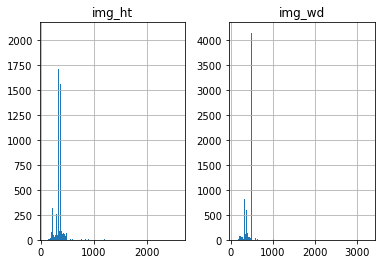

In [140]:
# get the image size distrubution
im_df[['img_ht','img_wd']].hist(bins=200)

In [141]:
# set image size
img_size = 150

In [142]:
# Updated function to read images by filename
# 150 x 150 images

im_df['img_mat_resize'] = im_df['img_mat'].apply(lambda x: [cv2.resize(x, (img_size, img_size)).astype(float)])
im_df['img_mat_resize']= im_df['img_mat_resize'].apply(lambda x: np.reshape(x,(img_size,img_size,1)))
# to use to_categorical, we need to have classes defined from 0 to num_class-1, so need to substract 1
im_df['class_id_catg'] = im_df['class_id'].apply(lambda x: np.reshape(to_categorical(x-1,num_classes=37,dtype='float32'),(1,37)))

In [143]:
# split to test(70%), train(20%) and Validation(10%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(im_df['img_mat_resize'],im_df['class_id_catg'], test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=2)
# in the Above, to get 10% from 80%, we need to get 1/8 =0.125 percentage of data

print('Training Set: ' + str(len(X_train))+' and labels:'+str(len(y_train))) # +' with '+ str(len(set(y_train))) +' unique classes')
print('Testing Set: ' + str(len(X_test))+' and labels:'+str(len(y_test)) ) #+' with ' + str(len(set(y_test))) +' unique classes')
print('Validation Set: ' + str(len(X_val))+' and labels:'+str(len(y_val)) ) #+' with ' + str(len(set(y_val))) +' unique classes')


Training Set: 5144 and labels:5144
Testing Set: 1470 and labels:1470
Validation Set: 735 and labels:735


## Task 1:

In [144]:
# define the DNN Model

model = Sequential([
  Conv2D(64, 7, input_shape=(img_size, img_size,1),activation='relu', name='1_conv2d'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='1_maxpool'),
  Conv2D(16, 5,activation='relu', name='2_conv2d'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='2_maxpool'),
  Conv2D(8, 3,activation='relu',name='3_conv2d'),
#   MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='3_maxpool'),
  Dense(128, activation='relu', name='1_dense'),
  AveragePooling2D(pool_size=(8,8), strides=(8,8),name='avg_pool'),
#   AveragePooling1D(pool_size=2,name='avg_pool',data_format='channels_first'),
#   GlobalMaxPooling1D(input_shape=(4096)),
  Flatten(name='flat_layer'),
  Dense(37, kernel_initializer=tf.keras.initializers.Zeros(),activation='softmax', name='final_dense')
])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_conv2d (Conv2D)            (None, 144, 144, 64)      3200      
_________________________________________________________________
1_maxpool (MaxPooling2D)     (None, 72, 72, 64)        0         
_________________________________________________________________
2_conv2d (Conv2D)            (None, 68, 68, 16)        25616     
_________________________________________________________________
2_maxpool (MaxPooling2D)     (None, 34, 34, 16)        0         
_________________________________________________________________
3_conv2d (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
1_dense (Dense)              (None, 32, 32, 128)       1152      
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 4, 4, 128)       

In [145]:
len(y_train.to_list()), len(X_train.to_list())


(5144, 5144)

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=False),
   loss=tf.keras.losses.CategoricalCrossentropy(),
   metrics=[tf.keras.metrics.CategoricalAccuracy()]
#   metrics=['accuracy']
)

In [ ]:
sess = tf.Session()
K.set_session(sess)
# model.fit(tf.convert_to_tensor(np.asarray(X_train.values).reshape(len(X_train), 1), dtype=float), tf.convert_to_tensor(np.asarray(y_train).reshape(len(X_train), 1), dtype=float), epochs=75,batch_size=10, verbose=1,validation_data=(tf.convert_to_tensor(np.asarray(X_val.values).reshape(len(X_val), 1), dtype=float), tf.convert_to_tensor(np.asarray(y_val).reshape(len(X_val), 1), dtype=float)))
# callbacks=model_callbacks)
history = model.fit(np.asarray(X_train.to_list()).flatten().reshape(len(X_train),img_size,img_size,1), np.asarray(y_train.to_list()).flatten().reshape(len(X_train),37), epochs=75,batch_size=32, verbose=1,validation_data=(np.asarray(X_val.to_list()).flatten().reshape(len(X_val),img_size,img_size,1), np.asarray(y_val.to_list()).flatten().reshape(len(X_val), 37)))

sess.close()

In [ ]:
# history = model.fit(np.asarray(X_train.to_list()).flatten().reshape(len(X_train),150,150,1), np.asarray(y_train.to_list()).flatten().reshape(len(X_train),37), epochs=75,batch_size=32, verbose=1,validation_data=(np.asarray(X_val.to_list()).flatten().reshape(len(X_val),150,150,1), np.asarray(y_val.to_list()).flatten().reshape(len(X_val), 37)))

# dat from history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# predict on Test Data.
y_pred = model.predict(np.asarray(X_test.to_list()).flatten().reshape(len(X_test),img_size,img_size,1))
# keras.metrics.CategoricalAccuracy(np.asarray(y_test.to_list()).flatten().reshape(len(y_test),37), y_pred)
def categorical_accuracy(y_test, y_pred):
    return K.mean(K.equal(K.argmax(y_test, axis=-1), K.argmax(y_pred, axis=-1)))

categorical_accuracy(np.asarray(y_test.to_list()).flatten().reshape(len(y_test),37), y_pred)

In [ ]:
y_pred[0]

In [ ]:
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(np.asarray(y_test.to_list()).flatten().reshape(len(y_test),37), y_pred)
m.result().numpy()

In [147]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=False),
   loss=tf.keras.losses.MeanSquaredError(),
  metrics=['accuracy']
)

In [148]:
sess = tf.Session()
K.set_session(sess)
# model.fit(tf.convert_to_tensor(np.asarray(X_train.values).reshape(len(X_train), 1), dtype=float), tf.convert_to_tensor(np.asarray(y_train).reshape(len(X_train), 1), dtype=float), epochs=75,batch_size=10, verbose=1,validation_data=(tf.convert_to_tensor(np.asarray(X_val.values).reshape(len(X_val), 1), dtype=float), tf.convert_to_tensor(np.asarray(y_val).reshape(len(X_val), 1), dtype=float)))
# callbacks=model_callbacks)
history = model.fit(np.asarray(X_train.to_list()).flatten().reshape(len(X_train),img_size,img_size,1), np.asarray(y_train.to_list()).flatten().reshape(len(X_train),37), epochs=75,batch_size=32, verbose=1,validation_data=(np.asarray(X_val.to_list()).flatten().reshape(len(X_val),img_size,img_size,1), np.asarray(y_val.to_list()).flatten().reshape(len(X_val), 37)))

sess.close()

Epoch 1/75
161/161 [==============================] - 98s 606ms/step - loss: 0.0263 - accuracy: 0.0354 - val_loss: 0.0263 - val_accuracy: 0.0599
Epoch 2/75
161/161 [==============================] - 92s 573ms/step - loss: 0.0262 - accuracy: 0.0521 - val_loss: 0.0262 - val_accuracy: 0.0762
Epoch 3/75
161/161 [==============================] - 693s 4s/step - loss: 0.0262 - accuracy: 0.0568 - val_loss: 0.0261 - val_accuracy: 0.0667
Epoch 4/75
161/161 [==============================] - 101s 629ms/step - loss: 0.0261 - accuracy: 0.0692 - val_loss: 0.0260 - val_accuracy: 0.0912
Epoch 5/75
161/161 [==============================] - 93s 578ms/step - loss: 0.0260 - accuracy: 0.0754 - val_loss: 0.0259 - val_accuracy: 0.0925
Epoch 6/75
161/161 [==============================] - 172s 1s/step - loss: 0.0259 - accuracy: 0.0797 - val_loss: 0.0258 - val_accuracy: 0.0966
Epoch 7/75
161/161 [==============================] - 93s 577ms/step - loss: 0.0258 - accuracy: 0.0935 - val_loss: 0.0258 - val_accur

161/161 [==============================] - 91s 568ms/step - loss: 0.0231 - accuracy: 0.2790 - val_loss: 0.0257 - val_accuracy: 0.1810
Epoch 58/75
161/161 [==============================] - 93s 576ms/step - loss: 0.0230 - accuracy: 0.2749 - val_loss: 0.0255 - val_accuracy: 0.1796
Epoch 59/75
161/161 [==============================] - 93s 575ms/step - loss: 0.0230 - accuracy: 0.2825 - val_loss: 0.0255 - val_accuracy: 0.1878
Epoch 60/75
161/161 [==============================] - 92s 573ms/step - loss: 0.0231 - accuracy: 0.2780 - val_loss: 0.0254 - val_accuracy: 0.1810
Epoch 61/75
161/161 [==============================] - 92s 570ms/step - loss: 0.0230 - accuracy: 0.2850 - val_loss: 0.0256 - val_accuracy: 0.1782
Epoch 62/75
161/161 [==============================] - 93s 575ms/step - loss: 0.0230 - accuracy: 0.2817 - val_loss: 0.0253 - val_accuracy: 0.1905
Epoch 63/75
161/161 [==============================] - 92s 572ms/step - loss: 0.0229 - accuracy: 0.2889 - val_loss: 0.0254 - val_accurac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


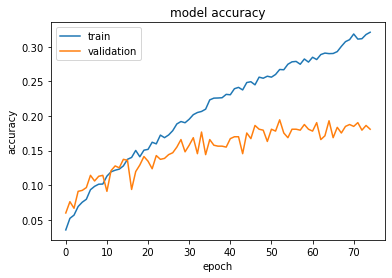

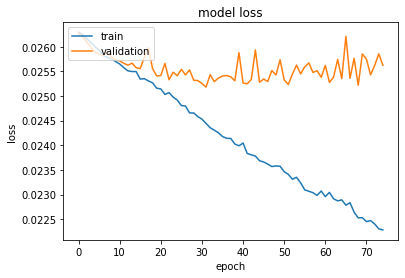

In [149]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [150]:
y_pred = model.predict(np.asarray(X_test.to_list()).flatten().reshape(len(X_test),img_size,img_size,1))
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(np.asarray(y_test.to_list()).flatten().reshape(len(y_test),37), y_pred)
m.result().numpy()

0.16462585

## Task 2: 

In [151]:
# define the DNN Model

model2 = Sequential([
  Conv2D(64, 7, input_shape=(img_size, img_size,1),activation='relu', name='1_conv2d'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='1_maxpool'),
  Conv2D(16, 5,activation='relu', name='2_conv2d'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='2_maxpool'),
  Conv2D(8, 3,activation='relu',name='3_conv2d'),
#   MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='3_maxpool'),
  Dense(128, activation='relu', name='1_dense'),
  AveragePooling2D(pool_size=(8,8), strides=(8,8),name='avg_pool'),
#   AveragePooling1D(pool_size=2,name='avg_pool',data_format='channels_first'),
#   GlobalMaxPooling1D(input_shape=(4096)),
  Flatten(name='flat_layer'),
 Dropout(0.25),
  Dense(37, kernel_initializer=tf.keras.initializers.Zeros(),activation='softmax', name='final_dense')
])
model2.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_conv2d (Conv2D)            (None, 144, 144, 64)      3200      
_________________________________________________________________
1_maxpool (MaxPooling2D)     (None, 72, 72, 64)        0         
_________________________________________________________________
2_conv2d (Conv2D)            (None, 68, 68, 16)        25616     
_________________________________________________________________
2_maxpool (MaxPooling2D)     (None, 34, 34, 16)        0         
_________________________________________________________________
3_conv2d (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
1_dense (Dense)              (None, 32, 32, 128)       1152      
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 4, 4, 128)       

In [152]:
model2.compile(
  optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=False),
   loss=tf.keras.losses.MeanSquaredError(),
  metrics=['accuracy']
)

In [153]:
sess = tf.Session()
K.set_session(sess)

history2 = model2.fit(np.asarray(X_train.to_list()).flatten().reshape(len(X_train),150,150,1), np.asarray(y_train.to_list()).flatten().reshape(len(X_train),37), epochs=75,batch_size=32, verbose=1,validation_data=(np.asarray(X_val.to_list()).flatten().reshape(len(X_val),150,150,1), np.asarray(y_val.to_list()).flatten().reshape(len(X_val), 37)))



Epoch 1/75
161/161 [==============================] - 123s 767ms/step - loss: 0.0263 - accuracy: 0.0321 - val_loss: 0.0263 - val_accuracy: 0.0503
Epoch 2/75
161/161 [==============================] - 121s 753ms/step - loss: 0.0263 - accuracy: 0.0377 - val_loss: 0.0263 - val_accuracy: 0.0571
Epoch 3/75
161/161 [==============================] - 101s 629ms/step - loss: 0.0262 - accuracy: 0.0529 - val_loss: 0.0262 - val_accuracy: 0.0626
Epoch 4/75
161/161 [==============================] - 99s 617ms/step - loss: 0.0262 - accuracy: 0.0612 - val_loss: 0.0261 - val_accuracy: 0.0707
Epoch 5/75
161/161 [==============================] - 100s 619ms/step - loss: 0.0261 - accuracy: 0.0667 - val_loss: 0.0260 - val_accuracy: 0.0735
Epoch 6/75
161/161 [==============================] - 99s 616ms/step - loss: 0.0261 - accuracy: 0.0686 - val_loss: 0.0260 - val_accuracy: 0.0735
Epoch 7/75
161/161 [==============================] - 98s 611ms/step - loss: 0.0260 - accuracy: 0.0733 - val_loss: 0.0259 - va

161/161 [==============================] - 98s 608ms/step - loss: 0.0228 - accuracy: 0.2858 - val_loss: 0.0250 - val_accuracy: 0.2000
Epoch 58/75
161/161 [==============================] - 99s 617ms/step - loss: 0.0227 - accuracy: 0.2953 - val_loss: 0.0251 - val_accuracy: 0.1850
Epoch 59/75
161/161 [==============================] - 106s 658ms/step - loss: 0.0228 - accuracy: 0.2904 - val_loss: 0.0254 - val_accuracy: 0.1837
Epoch 60/75
161/161 [==============================] - 99s 615ms/step - loss: 0.0226 - accuracy: 0.2949 - val_loss: 0.0252 - val_accuracy: 0.1796
Epoch 61/75
161/161 [==============================] - 105s 652ms/step - loss: 0.0224 - accuracy: 0.3038 - val_loss: 0.0251 - val_accuracy: 0.2014
Epoch 62/75
161/161 [==============================] - 105s 651ms/step - loss: 0.0226 - accuracy: 0.2970 - val_loss: 0.0253 - val_accuracy: 0.1986
Epoch 63/75
161/161 [==============================] - 115s 713ms/step - loss: 0.0224 - accuracy: 0.3079 - val_loss: 0.0255 - val_acc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


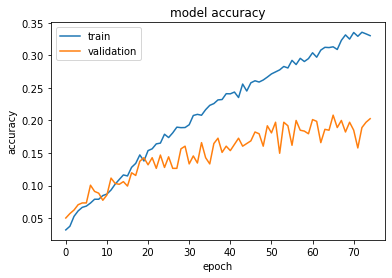

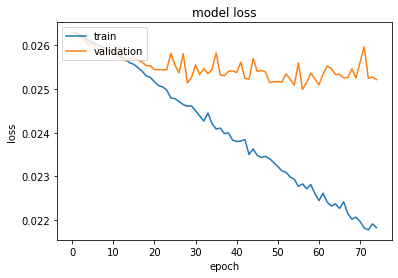

In [154]:
# dat from history
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [155]:
# predict on Test Data.
y_pred2 = model2.predict(np.asarray(X_test.to_list()).flatten().reshape(len(X_test),img_size,img_size,1))
# keras.metrics.CategoricalAccuracy(np.asarray(y_test.to_list()).flatten().reshape(len(y_test),37), y_pred)
def categorical_accuracy(y_test, y_pred):
    return K.mean(K.equal(K.argmax(y_test, axis=-1), K.argmax(y_pred, axis=-1)))

categorical_accuracy(np.asarray(y_test.to_list()).flatten().reshape(len(y_test),37), y_pred2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.1755102>

In [ ]:
np.argmax(y_pred2,axis=1)

In [156]:
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(np.asarray(y_test.to_list()).flatten().reshape(len(y_test),37), y_pred2)
m.result().numpy()

0.1755102

## Task 4:

In [157]:
# define the DNN Model

model4 = Sequential([
  Conv2D(64, 7, input_shape=(img_size, img_size,1),activation=tf.keras.activations.swish, name='1_conv2d'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='1_maxpool'),
  Conv2D(16, 5,activation=tf.keras.activations.swish, name='2_conv2d'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='2_maxpool'),
  Conv2D(8, 3,activation=tf.keras.activations.swish,name='3_conv2d'),
#   MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='3_maxpool'),
  Dense(128, activation=tf.keras.activations.swish, name='1_dense'),
  AveragePooling2D(pool_size=(8,8), strides=(8,8),name='avg_pool'),
#   AveragePooling1D(pool_size=2,name='avg_pool',data_format='channels_first'),
#   GlobalMaxPooling1D(input_shape=(4096)),
  Flatten(name='flat_layer'),
 Dropout(0.25),
  Dense(37, kernel_initializer=tf.keras.initializers.Zeros(),activation='softmax', name='final_dense')
])
model4.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_conv2d (Conv2D)            (None, 144, 144, 64)      3200      
_________________________________________________________________
1_maxpool (MaxPooling2D)     (None, 72, 72, 64)        0         
_________________________________________________________________
2_conv2d (Conv2D)            (None, 68, 68, 16)        25616     
_________________________________________________________________
2_maxpool (MaxPooling2D)     (None, 34, 34, 16)        0         
_________________________________________________________________
3_conv2d (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
1_dense (Dense)              (None, 32, 32, 128)       1152      
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 4, 4, 128)       

In [158]:
model4.compile(
  optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=False),
   loss=tf.keras.losses.MeanSquaredError(),
  metrics=['accuracy']
)

In [159]:
sess = tf.Session()
K.set_session(sess)

history4 = model4.fit(np.asarray(X_train.to_list()).flatten().reshape(len(X_train),150,150,1), np.asarray(y_train.to_list()).flatten().reshape(len(X_train),37), epochs=75,batch_size=32, verbose=1,validation_data=(np.asarray(X_val.to_list()).flatten().reshape(len(X_val),150,150,1), np.asarray(y_val.to_list()).flatten().reshape(len(X_val), 37)))

sess.close()

Epoch 1/75
161/161 [==============================] - 136s 842ms/step - loss: 0.0263 - accuracy: 0.0327 - val_loss: 0.0263 - val_accuracy: 0.0327
Epoch 2/75
161/161 [==============================] - 139s 864ms/step - loss: 0.0263 - accuracy: 0.0507 - val_loss: 0.0262 - val_accuracy: 0.0585
Epoch 3/75
161/161 [==============================] - 140s 870ms/step - loss: 0.0262 - accuracy: 0.0575 - val_loss: 0.0261 - val_accuracy: 0.0762
Epoch 4/75
161/161 [==============================] - 137s 854ms/step - loss: 0.0261 - accuracy: 0.0577 - val_loss: 0.0261 - val_accuracy: 0.0667
Epoch 5/75
161/161 [==============================] - 137s 853ms/step - loss: 0.0261 - accuracy: 0.0713 - val_loss: 0.0261 - val_accuracy: 0.0599
Epoch 6/75
161/161 [==============================] - 137s 849ms/step - loss: 0.0261 - accuracy: 0.0684 - val_loss: 0.0260 - val_accuracy: 0.0830
Epoch 7/75
161/161 [==============================] - 137s 850ms/step - loss: 0.0260 - accuracy: 0.0719 - val_loss: 0.0260 -

KeyboardInterrupt: 

In [ ]:
print(history4.history.keys())
# summarize history for accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# predict on Test Data.
y_pred4 = model4.predict(np.asarray(X_test.to_list()).flatten().reshape(len(X_test),img_size,img_size,1))

m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(np.asarray(y_test.to_list()).flatten().reshape(len(y_test),37), y_pred4)
m.result().numpy()

## Task 3:

#### 1. To Visualize the Filters on Convolutional Layer 1

7


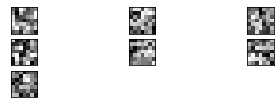

In [167]:
# retrieve weights from the second hidden layer
filters, biases = model2.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(len(filters))
# plot first few filters
n_filters, ix = 7, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

##### 2. To visualize the feature maps on Convolutional Layer 1

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_conv2d_input (InputLayer)  [(None, 150, 150, 1)]     0         
_________________________________________________________________
1_conv2d (Conv2D)            (None, 144, 144, 64)      3200      
Total params: 3,200
Trainable params: 3,200
Non-trainable params: 0
_________________________________________________________________
None


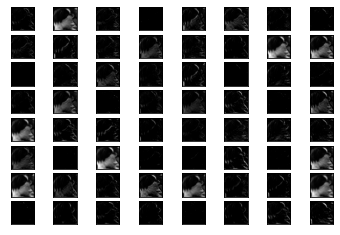

In [194]:
from keras.models import Model
# redefine model to output right after the first hidden layer
model_upd = Model(inputs=model2.inputs, outputs=model2.layers[0].output)
print(model_upd.summary())
# get a test image
img =  X_test.first
# plt.imshow(img)
# convert the image to the required type
img = np.asarray(X_train.to_list()).flatten()[:22500].reshape(1,150,150,1)

feature_maps = model_upd.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()